# The Cart-Pole Game

tutorial: https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb

## Setup

In [50]:
import io
import base64
import imageio
from pathlib import Path
import IPython
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL.Image
import pyvirtualdisplay

import gym
from gym import wrappers

import tensorflow as tf
from tensorflow import keras

from tf_agents.policies import policy_saver
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common 

## Hyperparameters

In [12]:
num_iterations = 20000

initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

## Environment

We will use the "CartPole-v0" from OpenAI Gym.
The observation returned on each time step is an array of 4 floats:

* positon of the cart
* velocity of the cart
* angular positon of the pole
* angular velocity of the pole

The reward returned on each time step is a scalar float value 1.0.
The possible actions are:

* 0: move left
* 1: move right

We created two environments, one for training and one for evaluation.
Each was then converted to TensorFlow using the `TFPYEnvironment` wrapper.

In [13]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00990847, -0.00630348, -0.0157035 , -0.00908371], dtype=float32))

In [14]:
env.time_step_spec().observation

BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

In [15]:
env.time_step_spec().reward

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

In [16]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)

In [17]:
env.close()

In [18]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

We will use a Deep Q-Network for this tutorial.
We start by creating the Q-Netowrk with 1 hidden layer with 100 neurons for this tutorial.

In [19]:
fc_layer_params = (100, )

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params
)

Then we can instantiate the DQN Agent.

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()

## Policies

The policy defines the way the agent acts in an environment.
Agents contain two policies:

1. `agent.policy`: The main policy that is used for evaluation and deployment.
2. `agent.collect_policy`: A second policy for data collection.

In [21]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can also be made from the `tf_agents.policies` module.
We will create another policy that randomly selects an action.

In [22]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

A policy returns an action when a `time_step` is passed to its `action()` method, where the `time_step` is an observation from the environment.
The `action()` method actually returns a tuple with three components: the action, the state (for stateful policies such as RNN-based policies), and auxilliary information (such as log probabilities of actions).

In [23]:
example_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
time_step = example_env.reset()
time_step

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0133165 ,  0.0167583 , -0.00924084,  0.01246492]],
      dtype=float32)>)

In [24]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Metrics and evaluation

The most common metric used to evaluate a policy is the average return where the return is the sum of rewards for an episone.
The `compute_avg_return()` function does just that for some `num_episodes` given an environment and a policy.

In [25]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [26]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.1

## Replay bufffer

The replay buffer keeps track of data collected from the environment.
This tutorial uses a `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, the most common choice.

The constructor requires the specifications for the data it will be collecting which is available in the agent as the `collect_data_spec` attribute.

In [27]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

The `collect_data_spec` of most agents is a `Trajectory`,  a named tuple containing the specs for observations, actions, rewards, and other items.

In [28]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [29]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data collections

We can collect the first data (i.e. prime the replay buffer) using the random policy.

In [30]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)

def collect_data(environment, policy, buffer, steps):
    for _ in range(steps):
        collect_step(environment, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

The replay buffer now has 100 Trajectory data points.
An example is shown below.

In [31]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02452128,  0.42900532, -0.01399936, -0.5506024 ], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=1>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>),
 BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=62>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))

The agent needs access to the replay buffer which we will accomplish by turning the replay buffer into a `tf.data.DataSet`.
Each row of the replay buffer only stores a single observation, but the DQN Agent needs both the current and next observation to compute the loss.
Therefore, the dataset pipeline will sample two adjacent rows for each item in the batch bby setting `num_steps=2`.

In [32]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [33]:
iterator = iter(dataset)
print(iterator)

## Training the agent

There are two main steps in the training loop:

1. Data is collected from the environment.
2. The data is used to train the agent's neural network.

In [36]:
# Optimize by wrapping this method as a TF function.
agent.train = common.function(agent.train)

# Reset the step counter.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy before starting.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    
    # Collect a few steps using the current policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    
    step = agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss}')
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)

step = 200: loss = 6.226707458496094
step = 400: loss = 4.420048236846924
step = 600: loss = 6.033348083496094
step = 800: loss = 9.891678810119629
step = 1000: loss = 13.52764892578125
step = 1000: Average Return = 79.30000305175781
step = 1200: loss = 39.75498962402344
step = 1400: loss = 51.85492706298828
step = 1600: loss = 24.995471954345703
step = 1800: loss = 91.72029113769531
step = 2000: loss = 116.82810974121094
step = 2000: Average Return = 39.900001525878906
step = 2200: loss = 95.27937316894531
step = 2400: loss = 45.41797637939453
step = 2600: loss = 52.61254119873047
step = 2800: loss = 184.23687744140625
step = 3000: loss = 70.09661102294922
step = 3000: Average Return = 95.0
step = 3200: loss = 22.291709899902344
step = 3400: loss = 24.119722366333008
step = 3600: loss = 196.63670349121094
step = 3800: loss = 135.13465881347656
step = 4000: loss = 149.40960693359375
step = 4000: Average Return = 155.8000030517578
step = 4200: loss = 104.2291030883789
step = 4400: loss 

## Visualization

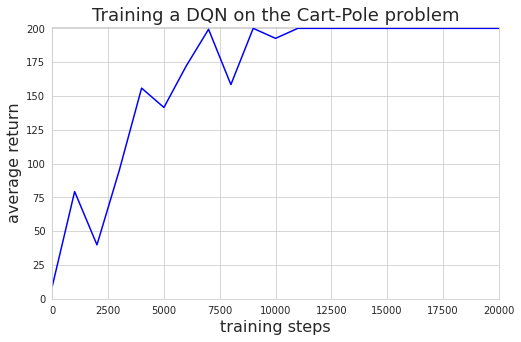

In [42]:
sns.set_style("whitegrid")

fig = plt.figure(figsize = (8, 5))
plt.plot(np.linspace(0, num_iterations, len(returns)), returns, 'b-')
plt.xlabel('training steps', fontsize=16)
plt.ylabel('average return', fontsize=16)
plt.title('Training a DQN on the Cart-Pole problem', fontsize=18)
plt.axis([0, num_iterations, 0, 201])
plt.show()

## Save model policy

In [52]:
saver = policy_saver.PolicySaver(agent.policy, batch_size=batch_size)
saver.save(Path("../models/cart-pole_dqn-policy.tfmdl").as_posix())

INFO:tensorflow:Assets written to: ../models/cart-pole_dqn-policy.tfmdl/assets
